In [1]:
%env SMILES=O

mol_name1 ="input"

density = 0.997                     #構造生成する際の密度をg/cm3の単位で書く。1より少し小さい値がお勧め 
max_atoms = 1200                    #ユニットセル中の全原子数                  
dt = 1                               #[fs] MDの刻み時間：このまま使うことを推奨。
reportInterval=5000                 #Logのインターバル時間 step数で書く。1000stepsであれば1ps
eq_temp = 300                        #緩和計算させるときの温度 [K]
system_press = 1.0                   #系の圧力 [atm] 
prod_steps = 100000                  #１つの温度条件での計算Steps数
eq_steps = 300000                    #緩和計算するstep数。この例だと100ps
eq_press = 1.0                       #緩和計算する際の系の圧力 [atm]
# 計算する温度の条件 [K]で書く
temps = [300]

gromacs_home = "/home/yamazaki/usr/local/gromacs/bin/"
#gromacs_home = "/opt/gromacs/bin/"

env: SMILES=O


In [2]:
#GAFF/AM1-BCCをアサインする
#%rm -r -f input.acpype
#%ls ./ |  grep -v -E 'dipoles_gromacs_IR.ipynb|dipoles_gromacs_nemd_scan.ipynb|system.mdp|pred_eps.txt'  | xargs rm -rf 

!echo ${SMILES} > input.smi
!obabel -ismi input.smi -O input.mol2 --gen3D --conformer --nconf 5000 --weighted 
!babel -imol2 input.mol2 -oxyz input.xyz
from ase.io import read, write
inp1 = read('input.xyz')
!acpype -i input.mol2 -c bcc -n 0 -m 1 -a gaff2 -f -o gmx -k "qm_theory='AM1',grms_tol=0.05,scfconv=1.d-10,ndiis_attempts=700, "

import shutil
src = './input.acpype/input_GMX.gro'
copy = './input1.gro'
shutil.copyfile(src,copy)
src = './input.acpype/input_GMX.itp'
copy = './input1.itp'
shutil.copyfile(src,copy)

1 molecule converted
1 molecule converted
3 info messages 6 audit log messages 
| ACPYPE: AnteChamber PYthon Parser interfacE v. 2020-10-24T12:16:34CEST (c) 2021 AWSdS |
==> ... charge set to 0
==> Executing Antechamber...
==> * Antechamber OK *
==> * Parmchk OK *
==> Executing Tleap...
++++++++++start_quote+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Checking 'HOH'....
Checking parameters for unit 'HOH'.
Checking for bond parameters.
Checking for angle parameters.
Unit is OK.
++++++++++end_quote+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
==> * Tleap OK *
==> Removing temporary files...
==> Writing GROMACS files

==> Writing GMX dihedrals for GMX 4.5 and higher.

==> Overwriting pickle file input.pkl
Total time of execution: 2s


'./input1.itp'

In [3]:
#構造可視化
import MDAnalysis as mda
import nglview as nv
from nglview.datafiles import PDB, XTC
#w = nv.show_ase(inp1,gui=True)
mol1 = mda.Universe('input1.gro')
w = nv.show_mdanalysis(mol1)
w.add_label(radius=1,color="black",label_type="atom")
w

NGLWidget()

In [4]:
#Production Run 
#OpenMMによるNVT計算
#トラジェクトリファイルh5を出力する
def run_nvt(temp,dt,steps,inp_file,out_file,nstlog):
    temp = temp 
    dt = dt 
    steps = steps 

    import mdtraj
        # OpenMM Imports
    import simtk.openmm as mm
    import simtk.openmm.app as app
    from openmmtools import integrators

    # ParmEd Imports
    from parmed import load_file
    from parmed.openmm.reporters import NetCDFReporter
    from parmed import unit as u
    
    eq_traj = mdtraj.load(inp_file+'.h5', 'r')
    eq_traj[-1].save_gro("pre.gro")

    # Load in a gromacs system
    from simtk.openmm import app
    gro = app.GromacsGroFile('pre.gro')
    top = app.GromacsTopFile('system.top', periodicBoxVectors=gro.getPeriodicBoxVectors(), includeDir="./")

    # Create the OpenMM system
    print('Creating OpenMM System')
    system = top.createSystem(nonbondedMethod=app.PME,
                          nonbondedCutoff=8.0*u.angstroms,
                          #constraints=app.HBonds,
                          removeCMMotion=True,
    )

    #barostat = mm.MonteCarloBarostat(pressure*u.bar, temp*u.kelvin,25)
    #system.addForce(barostat)

    # Create the integrator to do Langevin dynamics
    #integrator = mm.LangevinIntegrator(
    #                        temperature*u.kelvin,       # Temperature of heat bath
    #                        1.0/u.picoseconds,          # Friction coefficient
    #                        dt*u.femtoseconds,          # Time step
    #)

    timestep = dt * u.femtoseconds
    collision_rate = 1.0 / u.picoseconds
    temperature = temp * u.kelvin
    integrator = integrators.AndersenVelocityVerletIntegrator(temperature, collision_rate, timestep)

    # Define the platform to use; CUDA, OpenCL, CPU, or Reference. Or do not specify
    # the platform to use the default (fastest) platform
    platform = mm.Platform.getPlatformByName('CUDA')
    prop = dict(CudaPrecision='mixed') # Use mixed single/double precision

    # Create the Simulation object
    sim = app.Simulation(top.topology, system, integrator, platform, prop)

    # Set the particle positions
    sim.context.setPositions(gro.positions)

    #Molecular Dynamics
    sim.context.setVelocitiesToTemperature(temp*u.kelvin) 
    print('Running dynamics :Production')
    sim.context.setVelocitiesToTemperature(temp*u.kelvin) 
    sim.reporters.append(mdtraj.reporters.HDF5Reporter(out_file+'.h5', reportInterval, coordinates=True, time=True, cell=True, potentialEnergy=True, temperature=True))
    sim.reporters.append(mdtraj.reporters.DCDReporter(out_file+'.dcd', reportInterval))
    sim.reporters.append(
        app.StateDataReporter(out_file+"ene.csv", reportInterval, step=True, potentialEnergy=True,
                              kineticEnergy=True, temperature=True, volume=True,
                              density=True)
    )

    sim.step(steps)

    del sim # Make sure to close all files

In [5]:
def relax(dt):

    import pandas as pd
    
    import time 
    init_time = time.time()
    
    dt = dt

    #構造可視化
    import MDAnalysis as mda
    import nglview as nv
    from nglview.datafiles import PDB, XTC


    #混合溶液を作成
    import mdapackmol
    import numpy as np
    from ase import units

    # load individual molecule files
    mol1 = mda.Universe('input1.gro')
    #mol2 = mda.Universe('input2.gro')
    #total_mol = int(max_atoms/(mol1.atoms.n_atoms*conc+mol2.atoms.n_atoms*(1.0-conc)))
    total_mol = int(max_atoms/(mol1.atoms.n_atoms))
    num_mols1 = total_mol
    #num_mols1 = int(conc*total_mol)
    #num_mols2 = int((1.0-conc)*total_mol)

    mw_mol1 = np.sum(mol1.atoms.masses)
    #mw_mol2 = np.sum(mol2.atoms.masses)
    #print("Mw={}".format(mw_mol1))

    #total_weight = num_mols1 * mw_mol1 + num_mols2 * mw_mol2  
    total_weight = num_mols1 * mw_mol1 

    # Determine side length of a box with the density of mixture 
    d = density / 1e24 # Density in g/Ang3 
    volume = (total_weight / units.mol) / d
    L = volume**(1.0/3.0)

    system = mdapackmol.packmol(
    [ mdapackmol.PackmolStructure(
    mol1, number=num_mols1,
    instructions=['inside box 0. 0. 0. '+str(L)+"  "+str(L)+"  "+str(L)]),
    ])
    
    system.atoms.write('mixture.gro')

    import os 
    os.environ['GMX_MAXBACKUP'] = '-1'

    # for gromacs-5 or later 
    #commands = "gmx editconf -f mixture.gro  -box "+ str(L/10.0)+"  "+str(L/10.0)+"  "+str(L/10.0) + "  " +" -o init.gro"
    commands = "editconf -f mixture.gro  -box "+ str(L/10.0)+"  "+str(L/10.0)+"  "+str(L/10.0) + "  " +" -o init.gro"

    import subprocess
    from subprocess import PIPE

    proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
    output = proc.stdout
    #print('STDOUT: {}'.format(output))

    #make top file for GAFF

    top_file = "system.top"

    lines = [
        "; input_GMX.top created by acpype (v: 2020-07-25T09:06:13CEST) on Fri Jul 31 07:59:08 2020",
        ";by acpype (v: 2020-07-25T09:06:13CEST) on Fri Jul 31 07:59:08 2020",
        "   ",
        "[ defaults ]",
        "; nbfunc        comb-rule       gen-pairs       fudgeLJ fudgeQQ",
        "1               2               yes             0.5     0.8333",
        "    ",
        "; Include input.itp topology", 
        "#include \"input1.itp\"",
        "    ",
        "[ system ]",
        "input",
        "     ",
        "[ molecules ]",
        "; Compound        nmols" ,
        mol_name1 + "          " + str(int(num_mols1)), ]

    with open(top_file, mode='w') as f:
        f.write('\n'.join(lines))

    import sys
    import mdtraj

    # OpenMM Imports
    import simtk.openmm as mm
    import simtk.openmm.app as app
    from openmmtools import integrators

    # ParmEd Imports
    from parmed import load_file
    from parmed.openmm.reporters import NetCDFReporter
    from parmed import unit as u

    # Load in a gromacs system
    from simtk.openmm import app
    gro = app.GromacsGroFile('init.gro')
    top = app.GromacsTopFile('system.top', periodicBoxVectors=gro.getPeriodicBoxVectors(), includeDir="./")

    # Equilibration
    print('Creating OpenMM System')

    system = top.createSystem(nonbondedMethod=app.PME,
                  nonbondedCutoff=8.0*u.angstroms,
                  #constraints=app.HBonds,
                  removeCMMotion=True,
    )

    #barostat = mm.MonteCarloBarostat(eq_press*u.bar, eq_temp*u.kelvin, 25)
    #system.addForce(barostat)

    # Create the integrator to do Langevin dynamics
    #integrator = mm.LangevinIntegrator(
    #                        eq_temp*u.kelvin,       # Temperature of heat bath
    #                        1.0/u.picoseconds,  # Friction coefficient
    #                        dt*u.femtoseconds, # Time step
    #)

    timestep = dt * u.femtoseconds
    collision_rate = 1.0 / u.picoseconds
    temperature = eq_temp * u.kelvin
    integrator = integrators.AndersenVelocityVerletIntegrator(temperature, collision_rate, timestep)

    # Define the platform to use; CUDA, OpenCL, CPU, or Reference. Or do not specify
    # the platform to use the default (fastest) platform
    platform = mm.Platform.getPlatformByName('CUDA')
    prop = dict(CudaPrecision='mixed') # Use mixed single/double precision

    # Create the Simulation object
    sim = app.Simulation(top.topology, system, integrator, platform, prop)

    # Set the particle positions
    sim.context.setPositions(gro.positions)

    # Minimize the energy
    print('Minimizing energy')
    sim.minimizeEnergy(maxIterations=10000)

    #Relax the geometry 
    print('Running dynamics :Equilibration')
    sim.context.setVelocitiesToTemperature(eq_temp*u.kelvin) 
    sim.reporters.append(
        mdtraj.reporters.HDF5Reporter('eq_out.h5', 10000, coordinates=True, time=True, 
                                      cell=True, potentialEnergy=True, temperature=True))
    sim.reporters.append(
        app.StateDataReporter("eq_ene.csv", 10000, step=True, potentialEnergy=True,
                              kineticEnergy=True, temperature=True, volume=True,
                              density=True))
    sim.step(eq_steps)

    del sim # Make sure to close all files
    
    print("elapsed time= {} sec.".format(time.time()-init_time))

    #Production Run 
    dens = []
    inp_file = "eq_out"
    nstlog =1000
    for temp in temps :
        out_file = "resin"+str(temp)
        run_nvt(temp,dt,prod_steps,inp_file,out_file,nstlog)
        data = pd.read_csv(out_file+"ene.csv")
        dens.append(np.mean(data["Density (g/mL)"])) 
        inp_file = out_file
        dens=np.array(dens)

    import MDAnalysis as mda
    import nglview as nv
    from nglview.datafiles import PDB, XTC
    import mdapackmol
    import numpy as np
    from ase import units
    temp=temps[0]
    traj =mdtraj.load("resin"+str(temp)+".h5", 'r')
    traj[-1].save_gro("eq.gro")
    
    line = np.array([float(p) for p in tail("eq.gro",1)[0]]) 
    v = line[0]*line[1]*line[2]
    
    return v,line[0],line[1],line[2]

In [6]:
def tail(fn, n):
    # ファイルを開いてすべての行をリストで取得する
    with open(fn, 'r') as f:
        f.readline()
        lines = f.readlines()

    # 文字列を配列にしてから返す. ついでにstr->floatに型変換する
    return [line.strip().split() for line in lines[-n:]]

In [7]:
#make mdp file for dielectric dispersion 

mdp_file = "system.mdp"
temp =temps[0]
interval_steps = 2

lines = [
"; VARIOUS PREPROCESSING OPTIONS",
";title                    = Yo",
";cpp                      = /usr/bin/cpp",
"include                  =", 
"define                   =", 
"    ",
"; RUN CONTROL PARAMETERS",
"integrator               = md",
";integrator               = cg",
"; Start time and timestep in ps",
"tinit                    = 0",
"dt                       = 0.001",
"nsteps                   = 1000000",
"; For exact run continuation or redoing part of a run",
"init_step                = 0",
"; mode for center of mass motion removal",
";comm-mode                = Linear",
"; number of steps for center of mass motion removal",
";nstcomm                  = 1",
"; group(s) for center of mass motion removal",
";comm-grps                = ",
"    ",
"; ENERGY MINIMIZATION OPTIONS",
"; Force tolerance and initial step-size",
"emtol                    = 100",
"emstep                   = 0.01",
"; Max number of iterations in relax_shells",
"niter                    = 20",
"; Step size (1/ps^2) for minimization of flexible constraints",
"fcstep                   = 0",
"; Frequency of steepest descents steps when doing CG",
"nstcgsteep               = 1000",
"nbfgscorr                = 10",
"        ",
"; OUTPUT CONTROL OPTIONS",
"; Output frequency for coords (x), velocities (v) and forces (f)",
"nstxout                  = 0",
"nstvout                  = 0",
"nstfout                  = 0",
"; Checkpointing helps you continue after crashes",
"; THIS OPTION IS OBSOLETE",
";nstcheckpoint            = 1000",
"; Output frequency for energies to log file and energy file",
"nstlog                   = 1000",
"nstenergy                = 1000",
"; Output frequency and precision for xtc file",
"nstxtcout                = {}".format(interval_steps),
"xtc-precision            = 100000",
"; This selects the subset of atoms for the xtc file. You can",
"; select multiple groups. By default all atoms will be written.",
"xtc-grps                 = ",
"; Selection of energy groups",
"energygrps               = ",
"      ",
"; NEIGHBORSEARCHING PARAMETERS",
"; nblist update frequency",
"nstlist                  = 50",
"; ns algorithm (simple or grid)",
"ns_type                  = grid",
"; Periodic boundary conditions: xyz (default), no (vacuum)",
"; or full (infinite systems only)",
"pbc                      = xyz",
"; nblist cut-off        ",
"rlist                    = 1.0",
";domain-decomposition     = no",
"    ",
"; OPTIONS FOR ELECTROSTATICS AND VDW",
"; Method for doing electrostatics",
";coulombtype              = Cut-off",
";coulombtype              = Ewald",
"coulombtype              = pme",
";rcoulomb-switch          = 0",
"rcoulomb                 = 1.0",
"; Dielectric constant (DC) for cut-off or DC of reaction field",
"epsilon-r                = 1",
"; Method for doing Van der Waals",
"vdw-type                 = Cut-off",
"; cut-off lengths       ",
"rvdw-switch              = 0",
"rvdw                     = 1.0",
"; Apply long range dispersion corrections for Energy and Pressure",
"DispCorr                 = EnerPres",
"; Extension of the potential lookup tables beyond the cut-off",
"table-extension          = 1",
"; Spacing for the PME/PPPM FFT grid",
";fourierspacing           = 0.6",
"fourierspacing           = 0.12",
"; FFT grid size, when a value is 0 fourierspacing will be used",
"fourier_nx               = 0",
"fourier_ny               = 0",
"fourier_nz               = 0",
"; EWALD/PME/PPPM parameters",
"pme_order                = 4",
";pme_order                = 3",
"ewald_rtol               = 1e-05",
"ewald_geometry           = 3d",
"epsilon_surface          = 0",
"optimize_fft             = yes",
"      ",
"; GENERALIZED BORN ELECTROSTATICS",
"; Algorithm for calculating Born radii",
"gb_algorithm             = Still",
"; Frequency of calculating the Born radii inside rlist",
"nstgbradii               = 1",
"; Cutoff for Born radii calculation; the contribution from atoms",
"; between rlist and rgbradii is updated every nstlist steps",
"rgbradii                 = 2",
"; Salt concentration in M for Generalized Born models",
"gb_saltconc              = 0",
"      ",
"; IMPLICIT SOLVENT (for use with Generalized Born electrostatics)",
"implicit_solvent         = No",
"     ",
"; OPTIONS FOR WEAK COUPLING ALGORITHMS",
"; Temperature coupling  ",
"Tcoupl                   = nose-hoover",
";Tcoupl                   = Berendsen",
"; Groups to couple separately",
"tc-grps                  = System",
"; Time constant (ps) and reference temperature (K)",
"tau_t                    = 0.2 ",
"ref_t                    =  "+str(temp),
"; Pressure coupling     ",
"Pcoupl                   = No",
";Pcoupl                   = berendsen",
";Pcoupl                   = Parrinello-Rahman",
"Pcoupltype               = isotropic",
"; Time constant (ps), compressibility (1/bar) and reference P (bar)",
"tau_p                    = 1.0",
"compressibility          = 4.5e-5",
"ref_p                    = 1.0",
"; Random seed for Andersen thermostat",
"andersen_seed            = 815131",
"      ",
"; SIMULATED ANNEALING  ",
"; Type of annealing for each temperature group (no/single/periodic)",
"annealing                = no",
"; Number of time points to use for specifying annealing in each group",
"annealing_npoints        = ",
"; List of times at the annealing points for each group",
"annealing_time           = ",
"; Temp. at each annealing point, for each group.",
"annealing_temp           = ",
"        ",
"; GENERATE VELOCITIES FOR STARTUP RUN",
"gen_vel                  = yes",
"gen_temp                 = 298",
"gen_seed                 = -1",
"       ",
"; OPTIONS FOR BONDS    ",
";constraints              = all-bonds",
"constraints              = none",
"; Type of constraint algorithm",
"constraint-algorithm     = Lincs",
"; Do not constrain the start configuration",
"continuation      = no",
"; Use successive overrelaxation to reduce the number of shake iterations",
"Shake-SOR                = no",
"; Relative tolerance of shake",
"shake-tol                = 1e-04",
"; Highest order in the expansion of the constraint coupling matrix",
"lincs-order              = 4",
"; Number of iterations in the final step of LINCS. 1 is fine for",
"; normal simulations, but use 2 to conserve energy in NVE runs.",
"; For energy minimization with constraints it should be 4 to 8.",
"lincs-iter               = 1",
"; Lincs will write a warning to the stderr if in one step a bond",
"; rotates over more degrees than",
"lincs-warnangle          = 30",
"; Convert harmonic bonds to morse potentials",
"morse                    = no",
"      ",
"; ENERGY GROUP EXCLUSIONS",
"; Pairs of energy groups for which all non-bonded interactions are excluded",
"energygrp_excl           = ",
"       ",
"; NMR refinement stuff ",
"; Distance restraints type: No, Simple or Ensemble",
"disre                    = No",
"; Force weighting of pairs in one distance restraint: Conservative or Equal",
"disre-weighting          = Conservative",
"; Use sqrt of the time averaged times the instantaneous violation",
"disre-mixed              = no",
"disre-fc                 = 1000",
"disre-tau                = 0",
"; Output frequency for pair distances to energy file",
"; THIS IS OBSOLETE",
";nstdisreout              = 100 ",
"; Orientation restraints: No or Yes",
"orire                    = no",
"; Orientation restraints force constant and tau for time averaging",
"orire-fc                 = 0",
"orire-tau                = 0",
"orire-fitgrp             = ",
"; Output frequency for trace(SD) to energy file",
"nstorireout              = 100",
"; Dihedral angle restraints: No, Simple or Ensemble",
"dihre                    = No",
"dihre-fc                 = 1000",
";dihre-tau                = 0",
"; Output frequency for dihedral values to energy file",
";nstdihreout              = 100",
"       ",
"; Free energy control stuff",
"free-energy              = no",
"init-lambda              = 0",
"delta-lambda             = 0",
"sc-alpha                 = 0",
"sc-sigma                 = 0.3",
"      ",
"; Electric fields      ",
"; Format is number of terms (int) and for all terms an amplitude (real)",
"; and a phase angle (real)",
"E-x                      = ",
"E-xt                     = ",
"E-y                      = ",
"E-yt                     = ",
"E-z                      = ",
"E-zt                     = ",
"      ",
"; User defined thingies",
"user1-grps               = ",
"user2-grps               = ",
"userint1                 = 0",
"userint2                 = 0",
"userint3                 = 0",
"userint4                 = 0",
"userreal1                = 0",
"userreal2                = 0",
"userreal3                = 0",
"userreal4                = 0", 
]
    
with open(mdp_file, mode='w') as f:
    f.write('\n'.join(lines))

In [8]:
def calc(dt):
    # ParmEd Imports
    import pandas as pd
    
    dt = dt

    import time 
    init_time = time.time()

    from ase.io import read, write
    import MDAnalysis as mda
    import nglview as nv
    from nglview.datafiles import PDB, XTC

    #混合溶液を作成
    import mdapackmol
    import numpy as np
    from ase import units

    # load individual molecule files
    mol1 = mda.Universe('input1.gro')
    #mol2 = mda.Universe('input2.gro')
    #total_mol = int(max_atoms/(mol1.atoms.n_atoms*conc+mol2.atoms.n_atoms*(1.0-conc)))
    total_mol = int(max_atoms/(mol1.atoms.n_atoms))
    num_mols1 = total_mol
    #num_mols1 = int(conc*total_mol)
    #num_mols2 = int((1.0-conc)*total_mol)

    mw_mol1 = np.sum(mol1.atoms.masses)
    #mw_mol2 = np.sum(mol2.atoms.masses)
    #print("Mw={}".format(mw_mol1))

    #total_weight = num_mols1 * mw_mol1 + num_mols2 * mw_mol2  
    total_weight = num_mols1 * mw_mol1 

    # Determine side length of a box with the density of mixture 
    d = density / 1e24 # Density in g/Ang3 
    volume = (total_weight / units.mol) / d
    L = volume**(1.0/3.0)

    system = mdapackmol.packmol(
    [ mdapackmol.PackmolStructure(
    mol1, number=num_mols1,
    instructions=['inside box 0. 0. 0. '+str(L)+"  "+str(L)+"  "+str(L)]),
    ])
    
    system.atoms.write('mixture.gro')

    import os 
    os.environ['GMX_MAXBACKUP'] = '-1'

    # for gromacs-5 or later 
    #commands = "gmx editconf -f mixture.gro  -box "+ str(L/10.0)+"  "+str(L/10.0)+"  "+str(L/10.0) + "  " +" -o init.gro"
    commands = "editconf -f mixture.gro  -box "+ str(L/10.0)+"  "+str(L/10.0)+"  "+str(L/10.0) + "  " +" -o init.gro"

    import subprocess
    from subprocess import PIPE

    proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
    output = proc.stdout
    #print('STDOUT: {}'.format(output))

    #make top file for GAFF

    top_file = "system.top"

    lines = [
        "; input_GMX.top created by acpype (v: 2020-07-25T09:06:13CEST) on Fri Jul 31 07:59:08 2020",
        ";by acpype (v: 2020-07-25T09:06:13CEST) on Fri Jul 31 07:59:08 2020",
        "   ",
        "[ defaults ]",
        "; nbfunc        comb-rule       gen-pairs       fudgeLJ fudgeQQ",
        "1               2               yes             0.5     0.8333",
        "    ",
        "; Include input.itp topology", 
        "#include \"input1.itp\"",
        "    ",
        "[ system ]",
        "input",
        "     ",
        "[ molecules ]",
        "; Compound        nmols" ,
        mol_name1 + "          " + str(int(num_mols1)), ]

    with open(top_file, mode='w') as f:
        f.write('\n'.join(lines))

    import sys
    import mdtraj

    # OpenMM Imports
    import simtk.openmm as mm
    import simtk.openmm.app as app
    from openmmtools import integrators

    # ParmEd Imports
    from parmed import load_file
    from parmed.openmm.reporters import NetCDFReporter
    from parmed import unit as u

    # Load in a gromacs system
    from simtk.openmm import app
    gro = app.GromacsGroFile('init.gro')
    top = app.GromacsTopFile('system.top', periodicBoxVectors=gro.getPeriodicBoxVectors(), includeDir="./")

    # Equilibration
    print('Creating OpenMM System')

    system = top.createSystem(nonbondedMethod=app.PME,
                  nonbondedCutoff=8.0*u.angstroms,
                  #constraints=app.HBonds,
                  removeCMMotion=True,
    )

    #barostat = mm.MonteCarloBarostat(eq_press*u.bar, eq_temp*u.kelvin,25)
    #system.addForce(barostat)

    # Create the integrator to do Langevin dynamics
    #integrator = mm.LangevinIntegrator(
    #                        eq_temp*u.kelvin,       # Temperature of heat bath
    #                        1.0/u.picoseconds,  # Friction coefficient
    #                        dt*u.femtoseconds, # Time step
    #)

    timestep = dt * u.femtoseconds
    collision_rate = 1.0 / u.picoseconds
    temperature = eq_temp * u.kelvin
    integrator = integrators.AndersenVelocityVerletIntegrator(temperature, collision_rate, timestep)

    # Define the platform to use; CUDA, OpenCL, CPU, or Reference. Or do not specify
    # the platform to use the default (fastest) platform
    platform = mm.Platform.getPlatformByName('CUDA')
    prop = dict(CudaPrecision='mixed') # Use mixed single/double precision

    # Create the Simulation object
    sim = app.Simulation(top.topology, system, integrator, platform, prop)

    # Set the particle positions
    sim.context.setPositions(gro.positions)

    # Minimize the energy
    print('Minimizing energy')
    sim.minimizeEnergy(maxIterations=10000)

    #Relax the geometry 
    print('Running dynamics :Equilibration')
    sim.context.setVelocitiesToTemperature(eq_temp*u.kelvin) 
    sim.reporters.append(
        mdtraj.reporters.HDF5Reporter('eq_out.h5', 10000, coordinates=True, time=True, 
                                      cell=True, potentialEnergy=True, temperature=True))
    sim.reporters.append(
        app.StateDataReporter("eq_ene.csv", 10000, step=True, potentialEnergy=True,
                              kineticEnergy=True, temperature=True, volume=True,
                              density=True))
    sim.step(eq_steps)

    del sim # Make sure to close all files
    
    print("elapsed time= {} sec.".format(time.time()-init_time))

    #Production Run 
    dens = []
    inp_file = "eq_out"
    nstlog =1000
    for temp in temps :
        out_file = "resin"+str(temp)
        run_nvt(temp,dt,prod_steps,inp_file,out_file,nstlog)
        data = pd.read_csv(out_file+"ene.csv")
        dens.append(np.mean(data["Density (g/mL)"])) 
        inp_file = out_file
        dens=np.array(dens)
    print("MD done. elapsed time= {} sec.".format(time.time()-init_time))

    import MDAnalysis as mda
    import nglview as nv
    from nglview.datafiles import PDB, XTC
    import mdapackmol
    import numpy as np
    from ase import units
    temp=temps[0]
    traj =mdtraj.load("resin"+str(temp)+".h5", 'r')
    traj[-1].save_gro("eq.gro")

    #make mdp file for dielectric dispersion 
    mdp_file = "system.mdp"
    
    #grompp
    !export OMP_NUM_THREADS=1 
    commands = gromacs_home+"gmx_mpi grompp -f system.mdp -p system.top -c eq.gro -o run.tpr -maxwarn 10 "
    proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
    output = proc.stdout

    #mdrun
    !export OMP_NUM_THREADS=6
    commands = gromacs_home+"gmx_mpi mdrun -s run.tpr -o run.trr -e run.edr -nb gpu"
    proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
    output = proc.stdout
    print("mdrun done. elapsed time= {} sec.".format(time.time()-init_time))
    
    #input.txt for g_dipoles trjconv 
    commands = "echo System > input.txt"

    proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
    output = proc.stdout


    #make pdb file including connect info.
    #commands = gromacs_home+"gmx trjconv -s run.tpr -f traj_comp.xtc -dump -1 -conect -o run.pdb < input.txt"

    #proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
    #output = proc.stdout


    #resize xtc file 
    #commands = gromacs_home+"gmx trjconv -s run.tpr -f traj_comp.xtc -dt 10 -o traj_comp_resize.xtc < input.txt"

    #proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
    #output = proc.stdout

    #analysis 
    !export OMP_NUM_THREADS=1
    commands = gromacs_home+"gmx_mpi dipoles -s run.tpr -f traj_comp.xtc -o mtot1.xvg  -corr total -c acf1.xvg < input.txt"

    proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
    output = proc.stdout
    print("traj. analysis done. elapsed time= {} sec.".format(time.time()-init_time))

    #誘電率の値を抽出する
    import re
    regex = re.compile(r'([+-]?[0-9]+\.?[0-9]*)')
    pred_eps = np.array(regex.findall(output[-18:-1])).astype("float")[0]

    import pandas as pd
    acfs = pd.read_csv("acf1.xvg",header=0,delim_whitespace=True,names=("time","acf"),skiprows=17)
    #最終行を削除
    acfs = acfs[:-1]

    mtot = pd.read_csv("mtot1.xvg",header=0,delim_whitespace=True,names=("time","Mx","My","Mz","Mt"),skiprows=27)

    return pred_eps,acfs,mtot
    

In [9]:
import copy 
import pandas as pd 
from tqdm import tqdm

def calc_dt_dipole_acf(m):
    import statsmodels.api as sm
    import numpy as np
    mtot = m
    time = mtot["time"].to_numpy()
    dt = time[1]-time[0]
    print(dt)
    dmdt = (mtot["Mt"][2:].to_numpy() - mtot["Mt"][:-2].to_numpy())/(2.0*dt)
    dtime = time[1:-1]
    N=int(len(dmdt)/2)
    acf = sm.tsa.stattools.acf(dmdt,nlags=N,fft=False)

    M2    = np.mean(mtot["Mt"].to_numpy()**2)
    dmdt2 = np.mean(dmdt**2)
    cut_m = mtot["Mt"].to_numpy()[1:-1]
    dmdtM = np.mean(dmdt*cut_m)
    
    return [dtime[:len(acf)],acf,M2,dmdt2,dmdtM]
    
cycle = 20
for i in tqdm(range(cycle)):
    pred_eps,acfs,mtot=calc(dt)
    acfs["time"]=acfs["time"].astype(float)
    time_dmdt,acf_dmdt,M2,dM2,dMM = calc_dt_dipole_acf(mtot)
    
    if i==0 :
        pred_eps_ave = copy.deepcopy(pred_eps)
        acfs_ave = copy.deepcopy(acfs)
        acf_from_mtot_ave = acf_dmdt
        M2_ave  = M2
        dM2_ave = dM2
        dMM_ave = dMM
        
    if i > 0 :
        pred_eps_ave = (float(i)*pred_eps_ave + pred_eps) /(float(i)+1.0)
        c1 =float(2.0*i/(i+1))
        c2 =float(2.0/(i+1))
        df_concat = pd.concat((c1*acfs_ave, c2*acfs))
        by_row_index = df_concat.groupby(df_concat.index)
        acfs_ave = by_row_index.mean()
        acf_from_mtot_ave = (c1*acf_from_mtot_ave + c2*acf_dmdt)/2.0
        M2_ave  = (c1*M2_ave + c2*M2)/2.0
        dM2_ave = (c1*dM2_ave + c2*dM2)/2.0
        dMM_ave = (c1*dMM_ave + c2*dMM)/2.0


  0%|          | 0/20 [00:00<?, ?it/s]/home/yamazaki/miniconda3/envs/openmm/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/home/yamazaki/miniconda3/envs/openmm/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/home/yamazaki/miniconda3/envs/openmm/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/home/yamazaki/miniconda3/envs/openmm/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


Creating OpenMM System
Minimizing energy
Running dynamics :Equilibration
elapsed time= 59.6867470741272 sec.
Creating OpenMM System
Running dynamics :Production


/home/yamazaki/miniconda3/envs/openmm/lib/python3.6/site-packages/mdtraj/utils/validation.py:116: TypeCastPerformanceWarning: Casting xyz dtype=float64 to <class 'numpy.float32'> 
  TypeCastPerformanceWarning)


MD done. elapsed time= 75.36989331245422 sec.
mdrun done. elapsed time= 194.79205536842346 sec.
traj. analysis done. elapsed time= 263.58157324790955 sec.
0.002


  5%|▌         | 1/20 [04:43<1:29:48, 283.59s/it]/home/yamazaki/miniconda3/envs/openmm/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/home/yamazaki/miniconda3/envs/openmm/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/home/yamazaki/miniconda3/envs/openmm/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/home/yamazaki/miniconda3/envs/openmm/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


Creating OpenMM System
Minimizing energy
Running dynamics :Equilibration
elapsed time= 46.76357436180115 sec.
Creating OpenMM System
Running dynamics :Production


/home/yamazaki/miniconda3/envs/openmm/lib/python3.6/site-packages/mdtraj/utils/validation.py:116: TypeCastPerformanceWarning: Casting xyz dtype=float64 to <class 'numpy.float32'> 
  TypeCastPerformanceWarning)


MD done. elapsed time= 62.59156799316406 sec.
mdrun done. elapsed time= 175.27296257019043 sec.
traj. analysis done. elapsed time= 248.50465750694275 sec.
0.002


 10%|█         | 2/20 [09:07<1:21:32, 271.83s/it]

Creating OpenMM System
Minimizing energy
Running dynamics :Equilibration
elapsed time= 47.302443981170654 sec.
Creating OpenMM System
Running dynamics :Production
MD done. elapsed time= 63.0416214466095 sec.
mdrun done. elapsed time= 177.42605757713318 sec.
traj. analysis done. elapsed time= 250.4949185848236 sec.
0.002


 15%|█▌        | 3/20 [13:35<1:16:35, 270.35s/it]

Creating OpenMM System
Minimizing energy
Running dynamics :Equilibration
elapsed time= 47.789560079574585 sec.
Creating OpenMM System
Running dynamics :Production
MD done. elapsed time= 63.567418575286865 sec.
mdrun done. elapsed time= 180.50308179855347 sec.
traj. analysis done. elapsed time= 255.56991529464722 sec.
0.002


 20%|██        | 4/20 [18:07<1:12:14, 270.93s/it]

Creating OpenMM System
Minimizing energy
Running dynamics :Equilibration
elapsed time= 47.23973989486694 sec.
Creating OpenMM System
Running dynamics :Production
MD done. elapsed time= 63.2068088054657 sec.
mdrun done. elapsed time= 182.09874892234802 sec.
traj. analysis done. elapsed time= 257.4331691265106 sec.
0.002


 25%|██▌       | 5/20 [22:41<1:08:01, 272.11s/it]

Creating OpenMM System
Minimizing energy
Running dynamics :Equilibration
elapsed time= 47.25013852119446 sec.
Creating OpenMM System
Running dynamics :Production
MD done. elapsed time= 63.124345779418945 sec.
mdrun done. elapsed time= 181.7749059200287 sec.
traj. analysis done. elapsed time= 255.54421877861023 sec.
0.002


 30%|███       | 6/20 [27:14<1:03:31, 272.28s/it]

Creating OpenMM System
Minimizing energy
Running dynamics :Equilibration
elapsed time= 47.55234980583191 sec.
Creating OpenMM System
Running dynamics :Production
MD done. elapsed time= 63.56983947753906 sec.
mdrun done. elapsed time= 181.5038664340973 sec.
traj. analysis done. elapsed time= 257.96353006362915 sec.
0.002


 35%|███▌      | 7/20 [31:50<59:15, 273.49s/it]  

Creating OpenMM System
Minimizing energy
Running dynamics :Equilibration
elapsed time= 48.28282880783081 sec.
Creating OpenMM System
Running dynamics :Production
MD done. elapsed time= 64.196049451828 sec.
mdrun done. elapsed time= 186.95573568344116 sec.
traj. analysis done. elapsed time= 261.35048270225525 sec.
0.002


 40%|████      | 8/20 [36:28<54:59, 274.95s/it]

Creating OpenMM System
Minimizing energy
Running dynamics :Equilibration
elapsed time= 47.21459937095642 sec.
Creating OpenMM System
Running dynamics :Production
MD done. elapsed time= 63.08127975463867 sec.
mdrun done. elapsed time= 183.79872059822083 sec.
traj. analysis done. elapsed time= 260.19805455207825 sec.
0.002


 45%|████▌     | 9/20 [41:05<50:29, 275.45s/it]

Creating OpenMM System
Minimizing energy
Running dynamics :Equilibration
elapsed time= 47.334389209747314 sec.
Creating OpenMM System
Running dynamics :Production
MD done. elapsed time= 63.3156156539917 sec.
mdrun done. elapsed time= 183.96464109420776 sec.
traj. analysis done. elapsed time= 258.8268344402313 sec.
0.002


 50%|█████     | 10/20 [45:40<45:55, 275.56s/it]

Creating OpenMM System
Minimizing energy
Running dynamics :Equilibration
elapsed time= 47.39839196205139 sec.
Creating OpenMM System
Running dynamics :Production
MD done. elapsed time= 63.46980595588684 sec.
mdrun done. elapsed time= 185.0657603740692 sec.
traj. analysis done. elapsed time= 259.9758996963501 sec.
0.002


 55%|█████▌    | 11/20 [50:17<41:23, 275.96s/it]

Creating OpenMM System
Minimizing energy
Running dynamics :Equilibration
elapsed time= 47.617220878601074 sec.
Creating OpenMM System
Running dynamics :Production
MD done. elapsed time= 63.63734412193298 sec.
mdrun done. elapsed time= 187.68352794647217 sec.
traj. analysis done. elapsed time= 264.670939207077 sec.
0.002


 60%|██████    | 12/20 [54:59<37:00, 277.61s/it]

Creating OpenMM System
Minimizing energy
Running dynamics :Equilibration
elapsed time= 47.72706079483032 sec.
Creating OpenMM System
Running dynamics :Production
MD done. elapsed time= 63.769126892089844 sec.
mdrun done. elapsed time= 186.51636004447937 sec.
traj. analysis done. elapsed time= 261.646968126297 sec.
0.002


 65%|██████▌   | 13/20 [59:37<32:25, 277.97s/it]

Creating OpenMM System
Minimizing energy
Running dynamics :Equilibration
elapsed time= 47.570515155792236 sec.
Creating OpenMM System
Running dynamics :Production
MD done. elapsed time= 63.55286908149719 sec.
mdrun done. elapsed time= 186.31347012519836 sec.
traj. analysis done. elapsed time= 261.11244535446167 sec.
0.002


 70%|███████   | 14/20 [1:04:15<27:47, 277.99s/it]

Creating OpenMM System
Minimizing energy
Running dynamics :Equilibration
elapsed time= 47.27302265167236 sec.
Creating OpenMM System
Running dynamics :Production
MD done. elapsed time= 63.314044713974 sec.
mdrun done. elapsed time= 186.8830623626709 sec.
traj. analysis done. elapsed time= 263.46957874298096 sec.
0.002


 75%|███████▌  | 15/20 [1:08:57<23:15, 279.09s/it]

Creating OpenMM System
Minimizing energy
Running dynamics :Equilibration
elapsed time= 48.25410318374634 sec.
Creating OpenMM System
Running dynamics :Production
MD done. elapsed time= 64.33146262168884 sec.
mdrun done. elapsed time= 186.74632692337036 sec.
traj. analysis done. elapsed time= 262.0578579902649 sec.
0.002


 80%|████████  | 16/20 [1:13:36<18:36, 279.06s/it]

Creating OpenMM System
Minimizing energy
Running dynamics :Equilibration
elapsed time= 47.64222598075867 sec.
Creating OpenMM System
Running dynamics :Production
MD done. elapsed time= 63.706077575683594 sec.
mdrun done. elapsed time= 188.49961733818054 sec.
traj. analysis done. elapsed time= 263.7789378166199 sec.
0.002


 85%|████████▌ | 17/20 [1:18:17<13:58, 279.54s/it]

Creating OpenMM System
Minimizing energy
Running dynamics :Equilibration
elapsed time= 47.63132166862488 sec.
Creating OpenMM System
Running dynamics :Production
MD done. elapsed time= 63.92694306373596 sec.
mdrun done. elapsed time= 192.77277827262878 sec.
traj. analysis done. elapsed time= 271.2263813018799 sec.
0.002


 90%|█████████ | 18/20 [1:23:04<09:24, 282.00s/it]

Creating OpenMM System
Minimizing energy
Running dynamics :Equilibration


 90%|█████████ | 18/20 [1:23:05<09:13, 276.98s/it]


Exception: Particle coordinate is nan

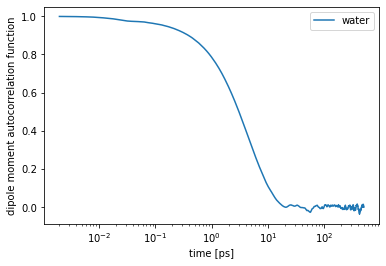

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

time = acfs_ave["time"].astype("float")
x00 = acfs_ave["acf"].astype("float")
plt.plot(time, x00 , label="water")

plt.xscale("log")
plt.legend()

plt.xlabel("time [ps]")
plt.ylabel("dipole moment autocorrelation function")
plt.show()

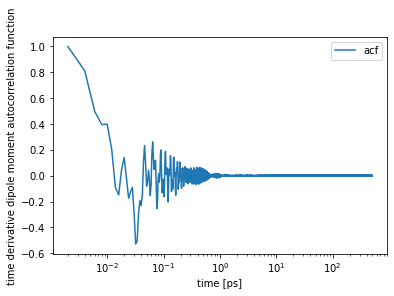

In [11]:
import statsmodels.api as sm
time = mtot["time"].to_numpy()[:len(acf_from_mtot_ave)]
plt.plot(time, acf_from_mtot_ave, label="acf")
plt.xscale("log")
plt.legend()

plt.xlabel("time [ps]")
plt.ylabel("time derivative dipole moment autocorrelation function")

plt.show()

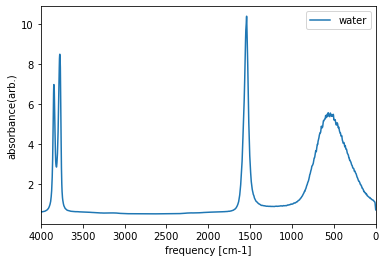

In [12]:
import numpy as np
alpha=0.1
acf2=acf_from_mtot_ave*np.exp(-alpha*time[:len(acf_from_mtot_ave)]**2)
w = (2.0 * np.pi * np.arange(len(acf2)) /(len(acf2)))/(time[1]-time[0])
f = w / (2.0*np.pi)
fcm = f*33.3
from scipy import fftpack
fft2 = fftpack.fft(acf2)
indx=int(len(fft2.real)/2)
plt.xlim(0,4000)
plt.plot(fcm[:indx], fft2.real[:indx] , label="water")
plt.gca().invert_xaxis()
plt.gca().patch.set_alpha(0)
plt.legend()

plt.xlabel("frequency [cm-1]")
plt.ylabel("absorbance(arb.)")

plt.show()

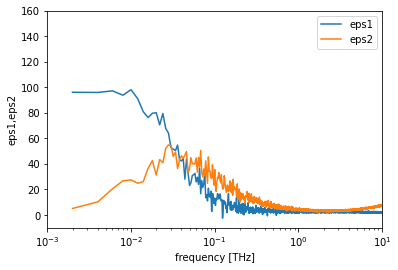

In [13]:
import numpy as np
from scipy import fftpack

eps_inf = 1 
eps_0 = pred_eps_ave

w = (2.0 * np.pi * np.arange(len(acf2)) /(len(acf2)))/(time[1]-time[0])
f = w / (2.0*np.pi)

Cm = acfs_ave["acf"].astype("float").to_numpy()
N=len(Cm)
fftCm = fftpack.fft(Cm)
indx=int(len(fftCm.real)/2)

# 正規化 √Nで割る
fftCm = fftCm/(np.sqrt(N))

eps1 = eps_0+w[1:indx]*(eps_0-eps_inf)*fftCm.imag[1:indx]
eps2 =       w[1:indx]*(eps_0-eps_inf)*fftCm.real[1:indx]

#eps1 = fftCm.imag[1:indx]*w[1:indx]

plt.xlim(0.001,10)
plt.plot(f[1:indx], eps1 , label="eps1")
plt.plot(f[1:indx], eps2 , label="eps2")

plt.legend()

plt.xlabel("frequency [THz]")
plt.ylabel("eps1,eps2")

plt.xscale("log") 

plt.show()

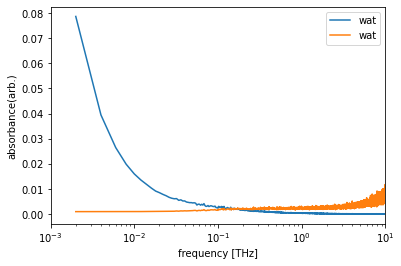

In [14]:
import numpy as np

w = (2.0 * np.pi * np.arange(len(acf2)) /(len(acf2)))/(time[1]-time[0])
f = w / (2.0*np.pi)

from scipy import fftpack
N = len(acf_from_mtot_ave)
fft2 = fftpack.fft(acf_from_mtot_ave)/(np.sqrt(N))
indx=int(len(fft2.real)/2)
plt.xlim(0.001,10)
plt.plot(f[1:indx], fft2.real[1:indx]/w[1:indx], label="wat")
plt.plot(f[1:indx], fft2.real[1:indx], label="wat")
plt.legend()

plt.xlabel("frequency [THz]")
plt.ylabel("absorbance(arb.)")

plt.xscale("log") 

plt.show()

In [15]:
#XTCを間引く
import subprocess
from subprocess import PIPE
steps = 0.01
!export OMP_NUM_THREADS=1
!echo System > input.txt
commands = gromacs_home+"gmx_mpi trjconv -s run.tpr -f traj_comp.xtc -dt {} -pbc mol -o traj_pbc.xtc  < input.txt".format(steps)
proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
output = proc.stdout

In [16]:
#分子運動の可視化
# Load in a gromacs system
from simtk.openmm import app
import mdtraj
#gro = app.GromacsGroFile('eq.gro')
eq_traj = mdtraj.load('resin300.h5', 'r')
eq_traj[-1].save_pdb("traj.pdb")

#n_total_atoms = len(gro.getPositions())
traj=mdtraj.load('traj_pbc.xtc',top="traj.pdb")
view=nv.show_mdtraj(traj,gui=True)
view.clear_representations()
view.parameters =dict(camera_type="orthographic",backgraound_color="black",clip_dist=0)
view.add_representation("ball+stick")
view.add_unitcell()
view.update_unitcell()
view

NGLWidget(max_frame=100000)